### GPU 상태 보기

In [1]:
!nvidia-smi

Mon Nov  1 20:22:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:01:00.0 Off |                  N/A |
| 34%   41C    P0   113W / 350W |      0MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:23:00.0 Off |                  N/A |
| 66%   

### GPU 번호 지정

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### 라이브러리 임포트

In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataset import KSponSpeechDataset, KSponSpeechDataCollate
from torch.utils.data import DataLoader
from kspon_jamo import n_symbols, text_to_tokens, tokens_to_text, SOS, EOS

### Dataset

In [4]:
dataset = KSponSpeechDataset(data_dir='dataset')
train_loader = DataLoader(dataset, num_workers=8, shuffle=True, batch_size=64, collate_fn=KSponSpeechDataCollate())
print(train_loader)

### Model Definition

In [7]:
class Model(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv1d(input_channels, hidden_channels, kernel_size=3, padding=1),
                                  nn.BatchNorm1d(hidden_channels),
                                  nn.ReLU())
        self.lstm = nn.LSTM(input_size=hidden_channels, hidden_size=hidden_channels//2, num_layers=3, 
                            batch_first=True, dropout=0.1, bidirectional=True)
        self.out_layer = nn.Linear(hidden_channels, output_channels)
        self.criterion = nn.CTCLoss(zero_infinity=True)
        
    def forward(self, inputs, input_lengths, targets, target_lengths):
        # inputs : (batch, mel_length, channel)
        # input_lengths : (batch)
        # targets : (batch, token_length)
        # target_lengths : (batch)
        
        '''Convolution'''
        # (batch, time, channel)
        x = self.conv(inputs.transpose(1, 2)).transpose(1, 2)
        
        '''LSTM'''
        x = nn.utils.rnn.pack_padded_sequence(x, input_lengths.cpu(), batch_first=True, enforce_sorted=False)
        x, _ = self.lstm(x)
        # (batch, time channel)
        x, _ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        
        '''Get Log-Probability'''
        # (batch, time, n_symbols)
        log_probs = F.log_softmax(self.out_layer(x), dim=2)
        
        '''Get CTC Loss'''
        loss = self.criterion(log_probs.transpose(0, 1), targets, input_lengths, target_lengths)
        
        return log_probs, loss
        

### Model Initialization

In [8]:
model = Model(input_channels=80, 
              hidden_channels=512, 
              output_channels=n_symbols)
model = model.cuda()
step = 0
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print('done')

done


### Batch data to cuda

In [9]:
def to_cuda(batch):
    batch['audio'] = batch['audio'].cuda()
    batch['audio_lengths'] = batch['audio_lengths'].cuda()
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    
    return batch

### Function to Train

In [15]:
def train_step(model, batch):
    # Set the model to train mode
    model.train()

    # Batch data to cuda
    batch = to_cuda(batch)

    # Set the gradient of the model to zero
    model.zero_grad()

    # Get the log-probability and the loss
    log_probs, loss = model(batch['audio'], batch['audio_lengths'], batch['text'], batch['text_lengths'])

    # Do backward propagation (calculate the gadients of the weights with respect to the loss)
    loss.backward()

    # Apply the gradients to the corresponding weights
    optimizer.step()
    
    return log_probs, loss

### Function to Plot

In [18]:
# Remove blank, SOS, EOS tokens
def refine_tokens(tokens):
    prev_token = None
    new_tokens = []
    for token in tokens:
        if prev_token == token:
            continue
        
        if token == 0 or token == SOS or token == EOS:
            prev_token = token
            continue
            
        new_tokens.append(token)
        prev_token = token
        
    return np.array(new_tokens)

def plot(batch, log_probs):
    import matplotlib.pyplot as plt
    import librosa.display
    
    _audio_lengths = batch['audio_lengths'].data.cpu().numpy()
    _audios = batch['audio'].data.cpu().numpy()
    _audio = _audios[0][:_audio_lengths[0]]
    _log_probs = log_probs.data.cpu().numpy()
    _log_prob = _log_probs[0][:_audio_lengths[0]]
    _text = batch['text'][0].data.cpu().numpy()
    _text_lengths = batch['text_lengths'].data.cpu().numpy()
    
    plt.figure(figsize=[18, 3])
    plt.title('Mel-spectrogram')
    librosa.display.specshow(_audio.T)
    plt.show()
    
    plt.figure(figsize=[18, 3])
    plt.title('Log-Probability')
    librosa.display.specshow(_log_prob.T)
    plt.show()
    
    print('Ground Truth')
    print(tokens_to_text(batch['text'][0, :batch['text_lengths'][0]].cpu().numpy()))
    tokens_pred = _log_prob.argmax(axis=1)
    tokens_refined = refine_tokens(tokens_pred)
    print('Prediction')
    print(tokens_to_text(tokens_refined))
    

### Create a directory to save checkpoints

In [25]:
!mkdir save

mkdir: cannot create directory ‘save’: File exists


### Train

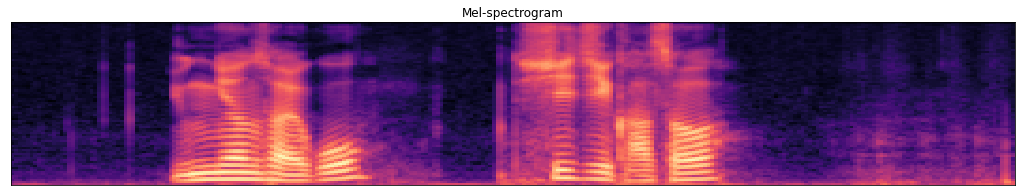

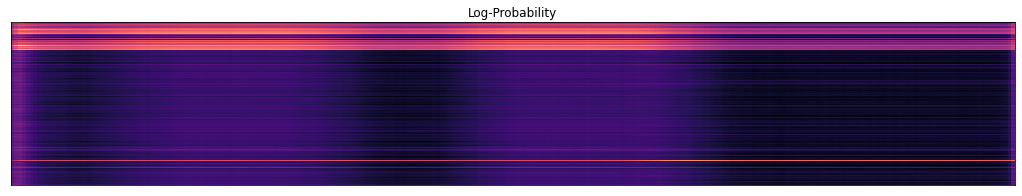

Ground Truth
육 년 살고 시지 가서
Prediction

710 2.5681185722351074
720 2.580244302749634
730 2.655641555786133
740 2.5088930130004883
750 2.579224109649658
760 2.535956859588623


In [ ]:
from IPython import display

while True: 
    for batch in train_loader:
        log_probs, loss = train_step(model, batch)
        
        if step % 10 == 0:
            print(step, loss.item())
            
        if step % 100 == 0:
            display.clear_output()
            plot(batch, log_probs)
        
        if step % 1000 == 0:
            path = 'save/checkpoint_' + str(step)
            torch.save({'step': step,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict()}, path)    
        step += 1
